# Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

# Open Data

Previously, signals were generated from the Dynamic Modeler and saved to csv files.

In this Notebook, the csv files are opened into Pandas DataFrames.

In [2]:
#Configure save paths
save_folder = "exports"
save_path = "{}\\{}\\".format(str(Path.cwd()), save_folder)

#Open signal data as DataFrames
df1 = pd.read_csv(save_path + 'x_dampeddriven.csv')
df2 = pd.read_csv(save_path + 'x_rlc.csv')

# Extract Training Data

A one dimensional signal needs to be properly formatted into an input and an output i.e. "label" for an LSTM model to train on it.

I define a function called create_dataset. It generates an input array and output array per training data point, through a series of overlapping windows. 


In [3]:
#Split data into multiple signals (inputs and labels) using a rolling window
def create_dataset(data, n_window, n_predict):
    #initialize data lists
    data_x = []
    data_y = []
    #initialize data
    for n in range(0, len(data)-n_window-n_predict):
        
        #Get training data
        #Training Inputs
        x = data[n:n+n_window]
        #Training Labels
        y = data[n+n_window:n+n_window+n_predict]
        
        #append training data and label to final format
        data_x += [x]
        data_y += [y]
    #convert lists to array
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    return data_x, data_y

In [4]:
#Determine length of training data
len_train = 4000

#Apply window function to prepare training data
n_window=600
n_predict=1
#damped oscillator data
x_train1, y_train1 = create_dataset(data=df1['x'].to_numpy()[0:len_train], n_window=n_window, n_predict=n_predict)
#rlc circuit data
x_train2, y_train2 = create_dataset(data=df2['capacitor voltage'].to_numpy()[0:len_train], n_window=n_window, n_predict=n_predict)

In [5]:
#Reshape input to be [samples, time steps, features]
x_train1 = np.expand_dims(x_train1, axis=1)
x_train2 = np.expand_dims(x_train2, axis=1)
x_train1.shape

(3399, 1, 600)

# Initiate and Train Model

TensorFlow neural networks consisting of one LSTM layer are created and fitted to the training data.

In [6]:
def create_model(x_length, y_length):
    """
    Description: 
        Create an LSTM model with specific parameters

    Args:
        x_length: int, length of training inputs
        y_lenght: int, length of training outputs
    """
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=n_predict, input_shape=(x_length, y_length)))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [12]:
#Determine model parameters
x_length = 1
epochs = 20
batch_size = 1

#Create neural networks as Tensorflow model objects
model1 = create_model(x_length=x_length, y_length=n_window)
model2 = create_model(x_length=x_length, y_length=n_window)
#Train Model
model1.fit(x_train1, y_train1, epochs=epochs, batch_size=batch_size, verbose=2)
model2.fit(x_train2, y_train2, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/20
3399/3399 - 3s - loss: 5.5405e-05 - 3s/epoch - 849us/step
Epoch 2/20
3399/3399 - 2s - loss: 5.1403e-05 - 2s/epoch - 619us/step
Epoch 3/20
3399/3399 - 2s - loss: 4.7861e-05 - 2s/epoch - 607us/step
Epoch 4/20
3399/3399 - 2s - loss: 4.2832e-05 - 2s/epoch - 635us/step
Epoch 5/20
3399/3399 - 2s - loss: 4.5182e-05 - 2s/epoch - 606us/step
Epoch 6/20
3399/3399 - 2s - loss: 4.7055e-05 - 2s/epoch - 604us/step
Epoch 7/20
3399/3399 - 2s - loss: 4.0441e-05 - 2s/epoch - 597us/step
Epoch 8/20
3399/3399 - 2s - loss: 4.9176e-05 - 2s/epoch - 606us/step
Epoch 9/20
3399/3399 - 2s - loss: 5.1075e-05 - 2s/epoch - 596us/step
Epoch 10/20
3399/3399 - 2s - loss: 4.4697e-05 - 2s/epoch - 593us/step
Epoch 11/20
3399/3399 - 2s - loss: 4.0719e-05 - 2s/epoch - 598us/step
Epoch 12/20
3399/3399 - 2s - loss: 4.6318e-05 - 2s/epoch - 599us/step
Epoch 13/20
3399/3399 - 2s - loss: 4.3759e-05 - 2s/epoch - 618us/step
Epoch 14/20
3399/3399 - 2s - loss: 3.8936e-05 - 2s/epoch - 629us/step
Epoch 15/20
3399/3399 - 3s - 

# Predict

The trained models are used to predict the outputs of the signals.

In [13]:
def predict(model, df, len_train, column_name):
    """
    Description:
        Make predictions from signals in dataframe df, using model
        
    Args:
        model: TensorFlow model

        df: pandas DataFrame

        len_train: int; the length of the training data

        column_name: str; name of the DataFrame column being predicted
    """
    
    #Iteratively make predictions using past predictions
    prediction_base = df[column_name].to_numpy()[0:len_train]
    list_prediction = []
    
    #iterate the same number of times as there is test data
    len_test = len(df[column_name]) - len_train
    for n in range(len_test):
    
        print('predicting timestep {} out of {}'.format(str(n), str(len_test)))
        #Make prediction
        prediction = model.predict(np.expand_dims(np.expand_dims(prediction_base[-1*n_window:], axis=0), axis=0))
    
        #Add prediction to prediction_base
        prediction_base=np.append(prediction_base, prediction[0])
        list_prediction+=[prediction[0]]
    
        #Add prediction to list of predictions
        list_prediction

    array_prediction = np.array(list_prediction)

    return model, array_prediction

In [14]:
model1, array_prediction1 = predict(model=model1, df=df1, len_train=len_train, column_name='x')
model2, array_prediction2 = predict(model=model2, df=df2, len_train=len_train, column_name='capacitor voltage')

predicting timestep 0 out of 1001
1/1 [==============================] - 1s 694ms/step
predicting timestep 1 out of 1001
1/1 [==============================] - 0s 18ms/step
predicting timestep 2 out of 1001
1/1 [==============================] - 0s 19ms/step
predicting timestep 3 out of 1001
1/1 [==============================] - 0s 18ms/step
predicting timestep 4 out of 1001
1/1 [==============================] - 0s 18ms/step
predicting timestep 5 out of 1001
1/1 [==============================] - 0s 19ms/step
predicting timestep 6 out of 1001
1/1 [==============================] - 0s 20ms/step
predicting timestep 7 out of 1001
1/1 [==============================] - 0s 18ms/step
predicting timestep 8 out of 1001
1/1 [==============================] - 0s 18ms/step
predicting timestep 9 out of 1001
1/1 [==============================] - 0s 20ms/step
predicting timestep 10 out of 1001
1/1 [==============================] - 0s 19ms/step
predicting timestep 11 out of 1001
1/1 [============

# Plot Results

Below, the predictions of the model are plotted against the actual signal (including both the training data and the hold out "future signal")

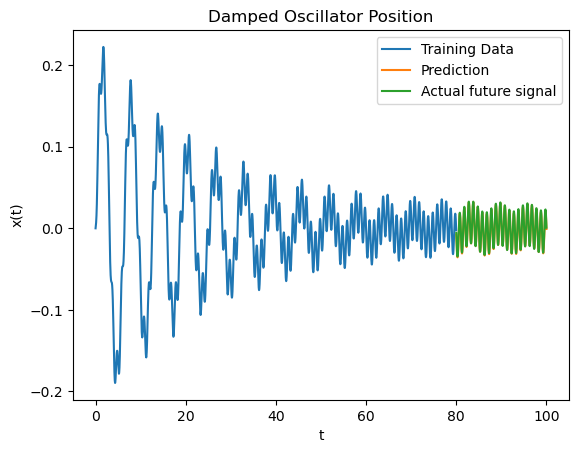

In [15]:
#Plot the actual signal
fig = plt.figure()
plt.title('Damped Oscillator Position')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.plot(df1['t'][0:len_train], df1['x'][0:len_train], label='Training Data')
plt.plot(df1['t'][-1*len(array_prediction1):], df1['x'][-1*len(array_prediction1):], label='Actual future signal')
plt.plot(df1['t'][-1*len(array_prediction1):],array_prediction1, label='Prediction')
plt.legend(loc='upper right')

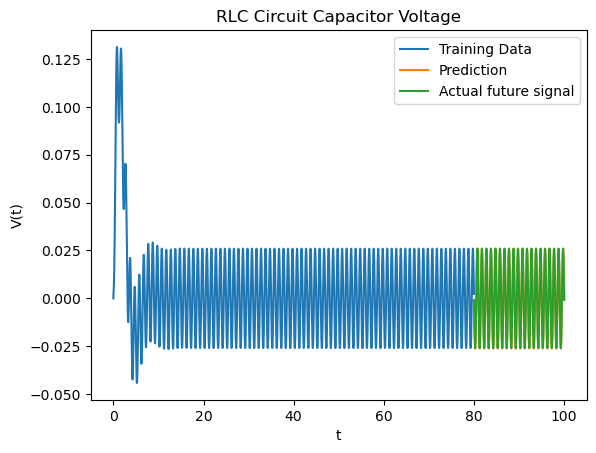

In [16]:
#Plot the actual signal
fig = plt.figure()
plt.title('RLC Circuit Capacitor Voltage')
plt.xlabel('t')
plt.ylabel('V(t)')
plt.plot(df2['t'][0:len_train], df2['capacitor voltage'][0:len_train], label='Training Data')
plt.plot(df2['t'][-1*len(array_prediction1):], df2['capacitor voltage'][-1*len(array_prediction2):], label='Actual future signal')
plt.plot(df2['t'][-1*len(array_prediction1):],array_prediction2, label='Prediction')
plt.legend(loc='upper right')